# LetsGrowMore (LGMVIP) - "DATA SCIENCE INTERNSHIP"
## LGMVIP Aug-22
## Ayush Dilip Padvekar
## Task - 10 ML Facial recognition to detect mood and suggest songs accordingly
This project is aimed at developing a machine learning model to analyze an image and detect the mood expressed in that image. According to the mood the model should further suggest songs as well.

We will be using Tensorflow and CNN for the purpose of model development.

Dataset Link: https://www.kaggle.com/datasets/msambare/fer2013

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

import warnings
warnings.filterwarnings("ignore")

### Loading the dataset

In [3]:
train_set = 'D:/Lets Grow More/10) ML Facial recognition to detect mood and suggest songs accordingly/archive/train/'
test_set = 'D:/Lets Grow More/10) ML Facial recognition to detect mood and suggest songs accordingly/archive/test/'

rows = 48
cols = 48
classes = len(os.listdir('D:/Lets Grow More/10) ML Facial recognition to detect mood and suggest songs accordingly/archive/train'))

In [4]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_set) :
    print(folder, "folder contains\t\t", len(os.listdir(train_set+folder)), "image")
    train_count.append(len(os.listdir(train_set+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_set) :
    print(folder, "folder contains\t\t", len(os.listdir(test_set+folder)), "images")
    test_count.append(len(os.listdir(test_set+folder)))

Train Set :
angry folder contains		 3995 image
disgust folder contains		 436 image
fear folder contains		 4097 image
happy folder contains		 7215 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


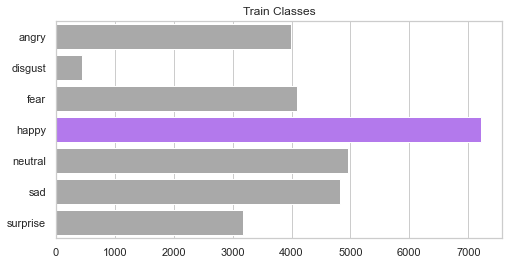

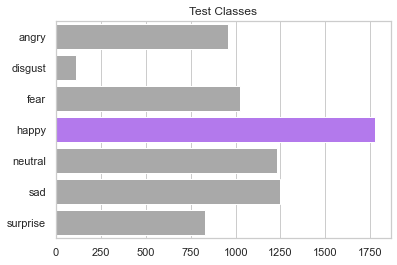

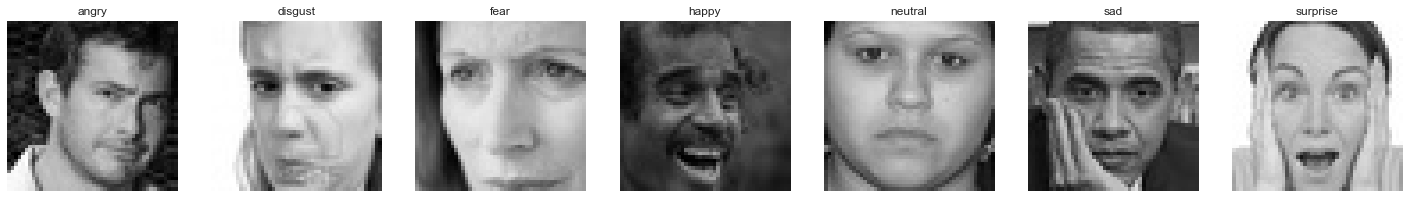

In [5]:
vals = ["happy"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_set)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_set),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_set),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_set):
    
    img = load_img((train_set + folder +'/'+ os.listdir(train_set + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

### Data Preprocessing

In [6]:
gen_train_data = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = gen_train_data.flow_from_directory(train_set,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

gen_test_data = ImageDataGenerator(rescale=1./255)
testing_set = gen_test_data.flow_from_directory(test_set,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Building Model

In [8]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((rows,cols,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

### Checkpoint

In [14]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [15]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = testing_set.n // testing_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=testing_set,
                  epochs=20,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 4.3093 - accuracy: 0.2722
Epoch 1: val_loss improved from inf to 5.69753, saving model to ferNet.h5
448/448 [==============================] - 1677s 4s/step - loss: 4.3093 - accuracy: 0.2722 - val_loss: 5.6975 - val_accuracy: 0.2528 - lr: 1.0000e-04
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 3.5387 - accuracy: 0.3311
Epoch 2: val_loss improved from 5.69753 to 3.20359, saving model to ferNet.h5
448/448 [==============================] - 1159s 3s/step - loss: 3.5387 - accuracy: 0.3311 - val_loss: 3.2036 - val_accuracy: 0.3940 - lr: 1.0000e-04
Epoch 3/20
448/448 [==============================] - ETA: 0s - loss: 3.0344 - accuracy: 0.3559
Epoch 3: val_loss improved from 3.20359 to 2.74679, saving model to ferNet.h5
448/448 [==============================] - 1186s 3s/step - loss: 3.0344 - accuracy: 0.3559 - val_loss: 2.7468 - val_accuracy: 0.4099 - lr: 1.0000e-04
Epoch 4/20
448/448 [============

### Model Evaluation

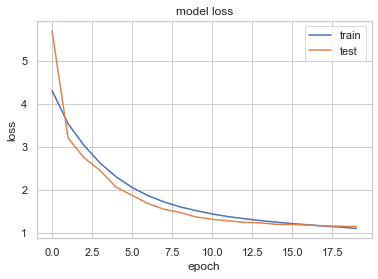

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

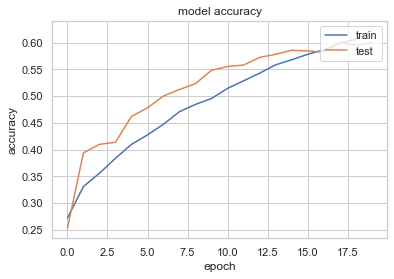

In [17]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [18]:
train_loss, train_acc = fernet.evaluate(training_set)
test_loss, test_acc = fernet.evaluate(testing_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

113/113 [==============================] - 62s 546ms/step - loss: 1.1513 - accuracy: 0.5999
final train accuracy = 67.26 , validation accuracy = 59.99


### 1. Training Set Classification Report and Heatmap

449/449 [==============================] - 264s 584ms/step
Confusion Matrix
[[ 680   32  440  975  825  642  401]
 [  71    1   42   97   87   86   52]
 [ 602   22  467 1053  836  665  452]
 [1111   51  849 1763 1536 1158  747]
 [ 735   38  568 1230 1024  839  531]
 [ 766   25  514 1224  995  806  500]
 [ 527   15  344  813  650  488  334]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.17      0.16      3995
     disgust       0.01      0.00      0.00       436
        fear       0.14      0.11      0.13      4097
       happy       0.25      0.24      0.25      7215
     neutral       0.17      0.21      0.19      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.18     28709



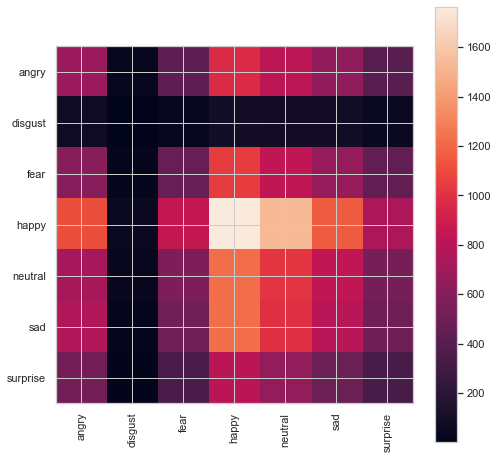

In [19]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### 1. Test Set Classification Report and Heatmap

113/113 [==============================] - 46s 408ms/step
Confusion Matrix
[[182   4 104 221 219 123 105]
 [ 20   1  10  27  22  14  17]
 [206   5 101 254 246 111 101]
 [352   7 190 406 396 227 196]
 [225   6 146 292 288 157 119]
 [236   3 141 294 278 161 134]
 [161   2  88 211 182  96  91]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.19      0.16       958
     disgust       0.04      0.01      0.01       111
        fear       0.13      0.10      0.11      1024
       happy       0.24      0.23      0.23      1774
     neutral       0.18      0.23      0.20      1233
         sad       0.18      0.13      0.15      1247
    surprise       0.12      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



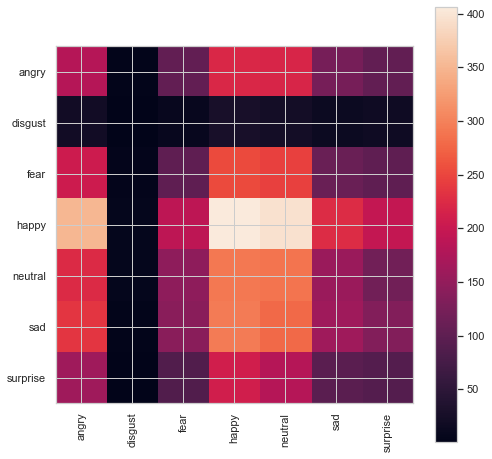

In [20]:
y_pred = fernet.predict(testing_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = testing_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(testing_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(testing_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Making songs predictions based on mood
### Loading the mood-song dataset

In [21]:
mood_music = pd.read_csv("D:/Lets Grow More/10) ML Facial recognition to detect mood and suggest songs accordingly/data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

,name,artist,mood
0,1999,Prince,Happy
1,23,Blonde Redhead,Sad
2,9 Crimes,Damien Rice,Sad
3,99 Luftballons,Nena,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,Energetic


### Loading a Sample Image for prediction

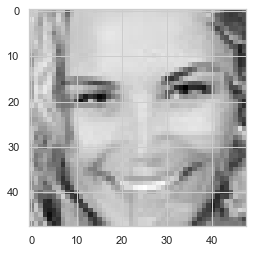

In [22]:
image = cv2.imread('D:/Lets Grow More/10) ML Facial recognition to detect mood and suggest songs accordingly/archive/test/happy/PrivateTest_10077120.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

### Preprocessing the sample image

In [23]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

1/1 [==============================] - 0s 398ms/step


3

### Suggesting songs based on mood

In [24]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

,index,name,artist,mood
0,112,Crash,Chris Malinchak,Happy
1,440,Reality,Chocolate Puma,Happy
2,456,Roses,OutKast,Happy
3,342,Message In A Bottle - Remastered 2003,The Police,Happy
4,530,Take Everything,Gareth Emery,Happy
